# Previsão de Transações Bancárias de Clientes

## Objetivo

Um banco necessita de um modelo que preveja se os clientes farão um tipo específico de transação a partir de dados anonimizados da sua base de clientes.
Para isso é preciso realizar uma classificação binária na variável alvo, em que 0 o cliente não fez a transação, 1 ele realizou.

## Dataset

Origem (Kaggle): https://www.kaggle.com/competitions/santander-customer-transaction-prediction/overview

O dataset de treino é composto por um conjunto de dados anônimo contendo variáveis de características numéricas, a coluna binária de alvo e uma coluna de ID_code.

O dataset de teste será utilizado para fazer o deploy do modelo e possui dados que não estão incluídos no dataset de treino.

## Ambiente

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

## Carregamento dos dados

In [2]:
df_treino = pd.read_csv('train.csv')

df_teste = pd.read_csv('test.csv')

In [3]:
df_treino.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
df_treino.shape

(200000, 202)

In [5]:
df_teste.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [6]:
df_teste.shape

(200000, 201)

## Pré-processamento dos dados

In [7]:
# Verficação das categorias da variável alvo
df_treino.target.value_counts()

target
0    179902
1     20098
Name: count, dtype: int64

Há um desbalanceamento dos dados da variável alvo, que será tratado em breve

In [8]:
# Converte de string para valor numérico
df_treino["target"] = df_treino["target"].astype(int)

In [9]:
df_treino.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [10]:
df_treino.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [11]:
# Verificando se há valores ausentes
df_treino.isnull().values.any()

False

In [12]:
# Verificando se há valores ausentes
df_teste.isnull().values.any()

False

In [13]:
# Extrai a lista de colunas
lista_de_colunas = df_treino.columns.tolist()

In [14]:
# Colunas das variáveis de entrada (input)
colunas_entrada = lista_de_colunas[2:202]

In [15]:
print(colunas_entrada)

['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 'var_10', 'var_11', 'var_12', 'var_13', 'var_14', 'var_15', 'var_16', 'var_17', 'var_18', 'var_19', 'var_20', 'var_21', 'var_22', 'var_23', 'var_24', 'var_25', 'var_26', 'var_27', 'var_28', 'var_29', 'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37', 'var_38', 'var_39', 'var_40', 'var_41', 'var_42', 'var_43', 'var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49', 'var_50', 'var_51', 'var_52', 'var_53', 'var_54', 'var_55', 'var_56', 'var_57', 'var_58', 'var_59', 'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_65', 'var_66', 'var_67', 'var_68', 'var_69', 'var_70', 'var_71', 'var_72', 'var_73', 'var_74', 'var_75', 'var_76', 'var_77', 'var_78', 'var_79', 'var_80', 'var_81', 'var_82', 'var_83', 'var_84', 'var_85', 'var_86', 'var_87', 'var_88', 'var_89', 'var_90', 'var_91', 'var_92', 'var_93', 'var_94', 'var_95', 'var_96', 'var_97', 'var_98', 'var_99', 'var_100'

In [16]:
# Checando se temos colunas duplicadas nos dados de entrada do treino
dup_cols = set([x for x in colunas_entrada if colunas_entrada.count(x) > 1])
print(dup_cols)
assert len(dup_cols) == 0, "você duplicou colunas em cols_input"

set()


In [17]:
# Checando se temos colunas duplicadas no dataset
dup_cols = set([x for x in lista_de_colunas if lista_de_colunas.count(x) > 1])
print(dup_cols)
assert len(dup_cols) == 0, "você duplicou colunas em cols_input"

set()


In [18]:
# Categorias da variável alvo
df_treino.target.value_counts()

target
0    179902
1     20098
Name: count, dtype: int64

In [19]:
# Esta função calcula a prevalência da classe positiva (label = 1)
def calcula_prevalencia(y_actual):
    return sum(y_actual) / len(y_actual)

In [20]:
print("Prevalência da classe positiva: %.3f"% calcula_prevalencia(df_treino["target"].values))

Prevalência da classe positiva: 0.100


### Divisão dos Dados Mantendo a Prevalência de Classe

In [21]:
# Gerando amostras aleatórias dos dados
df_data = df_treino.sample(n = len(df_treino))

In [22]:
df_data

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
178271,train_178271,0,9.9344,-7.0120,14.1335,4.6019,11.4039,-10.8923,4.4140,13.3000,...,7.1423,3.0445,2.1481,3.0993,14.6890,0.0498,13.6286,9.7320,19.4522,-1.0950
32727,train_32727,0,11.7801,-4.5880,10.8761,3.8457,10.9043,-15.2908,5.9276,21.7429,...,5.6012,9.7430,1.9387,3.5530,23.6616,0.3215,5.8315,9.4783,20.7338,5.9942
133412,train_133412,0,5.8714,-0.9918,12.8671,2.8055,11.2151,-15.5847,5.7161,12.6485,...,1.8714,4.0443,-0.5738,4.5290,17.6001,0.2033,0.8470,9.0163,16.7290,16.1292
174020,train_174020,0,16.2293,0.7140,11.4980,6.0280,9.9163,2.2274,4.9404,20.1963,...,4.1443,8.2415,0.2500,-0.7490,22.4154,-0.0182,-4.4592,8.9026,14.3935,0.0975
134780,train_134780,0,9.6904,7.6497,12.1778,6.1306,9.2023,10.8778,5.9081,21.4843,...,1.2210,9.6302,3.4054,-3.4349,16.6308,-0.0278,10.1042,8.7304,18.4972,-10.4925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99237,train_99237,0,12.5145,-2.8266,11.1755,4.8823,14.8023,0.7338,4.5118,17.4597,...,7.8672,9.8831,4.9902,6.9836,20.1270,-2.0521,8.0618,8.1303,20.2941,-12.1679
50665,train_50665,1,11.3431,-4.4953,16.7960,5.2002,12.7653,-7.7896,5.8708,14.1655,...,1.0111,5.7328,0.0777,7.2495,19.3916,-0.3846,2.7714,8.4193,14.0282,-8.2544
156425,train_156425,0,11.6386,5.1235,6.9606,9.8658,10.2102,-5.3553,4.0891,17.8196,...,9.8485,10.1223,-0.2840,10.9340,15.0287,0.6407,-3.3158,9.0194,11.8913,12.0996
30462,train_30462,0,12.1557,2.3822,15.8161,4.7152,11.0061,-17.2889,5.4733,15.1050,...,2.5716,10.6640,0.9401,10.0679,15.7892,0.8110,10.0128,8.9921,10.3948,13.9257


In [23]:
# Ajustando os índices do dataset
df_data = df_data.reset_index(drop = True)

In [24]:
df_data

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_178271,0,9.9344,-7.0120,14.1335,4.6019,11.4039,-10.8923,4.4140,13.3000,...,7.1423,3.0445,2.1481,3.0993,14.6890,0.0498,13.6286,9.7320,19.4522,-1.0950
1,train_32727,0,11.7801,-4.5880,10.8761,3.8457,10.9043,-15.2908,5.9276,21.7429,...,5.6012,9.7430,1.9387,3.5530,23.6616,0.3215,5.8315,9.4783,20.7338,5.9942
2,train_133412,0,5.8714,-0.9918,12.8671,2.8055,11.2151,-15.5847,5.7161,12.6485,...,1.8714,4.0443,-0.5738,4.5290,17.6001,0.2033,0.8470,9.0163,16.7290,16.1292
3,train_174020,0,16.2293,0.7140,11.4980,6.0280,9.9163,2.2274,4.9404,20.1963,...,4.1443,8.2415,0.2500,-0.7490,22.4154,-0.0182,-4.4592,8.9026,14.3935,0.0975
4,train_134780,0,9.6904,7.6497,12.1778,6.1306,9.2023,10.8778,5.9081,21.4843,...,1.2210,9.6302,3.4054,-3.4349,16.6308,-0.0278,10.1042,8.7304,18.4972,-10.4925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_99237,0,12.5145,-2.8266,11.1755,4.8823,14.8023,0.7338,4.5118,17.4597,...,7.8672,9.8831,4.9902,6.9836,20.1270,-2.0521,8.0618,8.1303,20.2941,-12.1679
199996,train_50665,1,11.3431,-4.4953,16.7960,5.2002,12.7653,-7.7896,5.8708,14.1655,...,1.0111,5.7328,0.0777,7.2495,19.3916,-0.3846,2.7714,8.4193,14.0282,-8.2544
199997,train_156425,0,11.6386,5.1235,6.9606,9.8658,10.2102,-5.3553,4.0891,17.8196,...,9.8485,10.1223,-0.2840,10.9340,15.0287,0.6407,-3.3158,9.0194,11.8913,12.0996
199998,train_30462,0,12.1557,2.3822,15.8161,4.7152,11.0061,-17.2889,5.4733,15.1050,...,2.5716,10.6640,0.9401,10.0679,15.7892,0.8110,10.0128,8.9921,10.3948,13.9257


In [25]:
# Extrai uma amostra de 30% dos dados de forma aleatória
df_amostra_30 = df_data.sample(frac = 0.3)

In [26]:
df_amostra_30

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
194850,train_65778,0,11.2910,-6.3781,8.8628,7.6732,11.2231,-8.0846,5.1340,17.4799,...,-1.3387,7.5980,2.5849,0.3021,13.5971,1.2786,4.6881,7.5842,14.4100,-6.4652
39806,train_150124,0,11.0185,-6.8476,11.5444,8.9322,12.7027,-0.9809,4.2496,21.8585,...,9.3943,5.2239,2.1649,1.0102,20.0030,-3.8901,2.3914,8.3961,14.5451,-12.9616
127403,train_81862,0,11.0890,3.1469,8.2033,4.2529,8.5553,-0.0377,6.4454,16.0456,...,9.8597,8.7877,3.1349,-0.9134,22.1231,0.5353,2.6544,9.7971,14.1253,-3.2640
30695,train_165668,0,12.3813,-3.8891,12.2119,4.0035,11.3942,-8.8991,3.8521,15.8721,...,-3.7914,6.2923,3.0472,1.6083,17.0332,-1.1796,-2.1657,8.7708,14.5392,1.1032
199798,train_124999,1,9.0325,-5.2033,16.6835,6.1792,9.3122,-17.2118,7.5428,18.7603,...,-4.3695,5.9243,3.3830,-0.3592,18.8342,0.4219,1.1858,8.7084,19.6993,2.9893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31188,train_85143,1,7.4615,-1.3869,7.8136,9.2925,10.6295,2.9203,5.0861,16.6448,...,7.7239,8.0464,1.6980,-0.1182,14.8964,-0.8249,10.2281,8.1463,20.2243,9.9118
73937,train_105482,0,13.2964,-3.7249,10.7330,4.0752,11.1602,0.0712,5.4336,12.0277,...,-0.0348,6.9053,2.0876,-0.2079,17.7124,-1.3130,-6.2290,10.2746,19.6897,-22.3198
17766,train_74188,0,10.1185,-2.2885,10.9108,3.3648,10.7475,-16.3387,4.8925,12.5873,...,7.2448,4.8828,3.3029,4.3702,21.0259,0.1655,9.2987,9.9126,15.1519,-17.5141
79162,train_43812,1,12.8436,-1.3190,13.1624,8.4914,10.0474,-16.3317,5.2111,15.0915,...,-1.3159,3.1329,-0.0767,10.7556,20.6209,-1.3838,6.9542,8.2519,17.2059,-8.1250


In [27]:
print("Tamanho da divisão de validação / teste: %.1f" % (len(df_amostra_30) / len(df_data)))

Tamanho da divisão de validação / teste: 0.3


In [28]:
# Fazendo a divisão

# Dados de teste
df_teste = df_amostra_30.sample(frac = 0.5)

# Dados se validação
df_valid = df_amostra_30.drop(df_teste.index)

# Dados de treino
df_treino = df_data.drop(df_amostra_30.index)

In [29]:
df_teste

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
72908,train_67598,0,12.9523,1.0696,14.0402,4.5694,10.6358,-0.8595,5.1979,18.5653,...,0.5979,12.8313,0.6603,-2.5672,20.5835,2.8912,-5.8712,8.9594,12.5136,7.3947
32217,train_30712,0,5.7043,3.4519,10.5188,9.4177,13.9082,-5.5604,5.2884,13.3352,...,3.5086,10.0014,0.8298,0.5026,19.0199,-0.1699,5.4770,6.9893,14.0056,-20.3126
71172,train_66254,1,11.9884,7.1638,9.8993,6.3018,13.0679,-11.4986,7.2637,17.8306,...,0.9718,10.8906,0.8551,1.6856,17.3631,-0.0037,-2.8405,8.6355,16.8451,-5.1234
181547,train_3096,0,8.3060,-3.5546,11.5174,5.6410,11.9246,-0.0016,4.3605,11.4286,...,11.6000,15.2616,1.4389,-0.1642,23.8743,3.1085,2.4295,10.0806,12.7034,0.9532
98657,train_11933,0,13.1105,-6.2290,7.2857,6.1434,13.3822,-2.2312,4.4955,18.2397,...,-1.4340,6.3732,2.3070,3.9573,20.1491,0.7485,1.9833,9.6393,13.0146,7.1926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189311,train_43357,0,14.4912,4.9444,9.7225,4.7806,8.3405,-12.8200,5.9330,14.4074,...,3.8071,5.1900,0.5513,4.3136,22.1240,-0.3981,3.9170,8.2682,13.5327,6.2626
17141,train_192195,0,12.2092,-3.2662,12.1467,6.3765,10.6182,-10.7203,5.8313,22.6764,...,3.6428,6.2390,1.2036,-2.7037,14.5630,-0.0510,-0.9131,9.3635,18.6513,15.9555
191312,train_147330,0,17.4595,-2.2044,16.9123,9.1552,14.4017,1.3751,5.8942,22.6673,...,6.6654,4.1548,-0.8103,-2.8741,14.7264,2.9534,-0.2983,10.0618,13.6127,-7.0119
9572,train_17706,0,8.9958,-6.2253,11.6089,7.2854,11.2381,-9.2732,4.6971,18.2812,...,4.8618,11.4672,0.3207,2.0000,15.3550,0.4750,2.8186,10.0912,15.9114,2.8390


In [30]:
df_valid

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
127403,train_81862,0,11.0890,3.1469,8.2033,4.2529,8.5553,-0.0377,6.4454,16.0456,...,9.8597,8.7877,3.1349,-0.9134,22.1231,0.5353,2.6544,9.7971,14.1253,-3.2640
199798,train_124999,1,9.0325,-5.2033,16.6835,6.1792,9.3122,-17.2118,7.5428,18.7603,...,-4.3695,5.9243,3.3830,-0.3592,18.8342,0.4219,1.1858,8.7084,19.6993,2.9893
73497,train_147388,0,10.7536,1.8597,14.6335,3.3248,13.2764,-16.5187,6.0579,15.1286,...,8.6536,8.2695,1.4421,7.2712,13.5105,0.7768,4.8650,7.1525,16.8197,-1.4312
192139,train_71252,0,13.2630,-9.8175,11.2641,5.9799,13.2996,-4.9003,6.2194,14.1823,...,3.8401,10.2803,1.9005,9.6662,17.0843,-2.2615,-0.7671,10.0063,8.3026,-13.0333
90276,train_140777,0,9.6602,7.8753,8.8874,5.9655,10.1219,-19.9984,5.7780,11.5357,...,4.6612,7.1213,-0.6746,0.8563,16.5155,-0.9912,5.3834,9.2381,18.8693,-5.5850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187052,train_125776,0,14.2491,-6.1479,11.9448,3.1277,12.6847,-15.2928,7.3964,16.6428,...,4.5193,5.8561,4.9846,6.1645,17.9745,0.7752,2.5080,8.0290,14.9070,-9.5365
26028,train_197705,0,8.2927,-0.8612,12.0051,6.7477,11.9255,-14.9613,5.0187,13.7417,...,0.7273,7.5470,0.1394,5.2329,18.9900,-1.3781,5.1298,8.0798,16.3395,6.4900
127627,train_137730,0,10.8793,-1.1744,13.6141,7.9190,9.3216,-16.0056,5.9210,23.4731,...,-7.4759,12.3526,2.6935,2.4193,18.5522,0.9723,8.2289,7.6837,19.0196,-13.7124
58369,train_137356,0,11.5624,-1.6288,11.2181,7.5343,9.8267,6.2715,5.8450,13.0114,...,-0.6504,4.7503,3.4999,-1.1367,16.7816,-1.2929,-1.2546,10.1138,9.7003,-2.8515


In [31]:
df_treino

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_178271,0,9.9344,-7.0120,14.1335,4.6019,11.4039,-10.8923,4.4140,13.3000,...,7.1423,3.0445,2.1481,3.0993,14.6890,0.0498,13.6286,9.7320,19.4522,-1.0950
1,train_32727,0,11.7801,-4.5880,10.8761,3.8457,10.9043,-15.2908,5.9276,21.7429,...,5.6012,9.7430,1.9387,3.5530,23.6616,0.3215,5.8315,9.4783,20.7338,5.9942
2,train_133412,0,5.8714,-0.9918,12.8671,2.8055,11.2151,-15.5847,5.7161,12.6485,...,1.8714,4.0443,-0.5738,4.5290,17.6001,0.2033,0.8470,9.0163,16.7290,16.1292
5,train_133256,0,5.8113,-4.2302,10.8594,6.5288,12.9707,-17.3761,6.4570,14.7018,...,-0.5024,4.2444,1.8524,11.3001,18.0994,0.3668,7.0928,10.0605,18.6315,11.4655
6,train_199576,0,9.6064,2.2505,6.6767,9.1723,11.5929,-1.0396,5.2622,22.8160,...,6.2009,8.1483,0.7215,0.4521,13.2882,-0.2740,4.4424,9.5755,18.3230,-4.0896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,train_87103,0,13.4837,-6.6854,7.1533,10.8237,11.1229,-10.2488,4.3870,20.6109,...,4.6567,11.9176,-1.4452,-0.3120,17.4910,1.9419,3.4210,8.7156,15.1749,-3.8987
199994,train_20976,0,12.2267,-0.7222,6.4513,3.8624,10.6939,5.3638,4.4110,21.4447,...,5.1192,10.0843,3.0982,3.5480,25.3552,1.3342,-11.4658,9.5909,16.7745,-14.7709
199996,train_50665,1,11.3431,-4.4953,16.7960,5.2002,12.7653,-7.7896,5.8708,14.1655,...,1.0111,5.7328,0.0777,7.2495,19.3916,-0.3846,2.7714,8.4193,14.0282,-8.2544
199998,train_30462,0,12.1557,2.3822,15.8161,4.7152,11.0061,-17.2889,5.4733,15.1050,...,2.5716,10.6640,0.9401,10.0679,15.7892,0.8110,10.0128,8.9921,10.3948,13.9257


In [32]:
# Verifique a prevalência de cada subconjunto
print(
    "Teste(n = %d): %.3f"
    % (len(df_teste), calcula_prevalencia(df_teste.target.values))
)
print(
    "Validação(n = %d): %.3f"
    % (len(df_valid), calcula_prevalencia(df_valid.target.values))
)
print(
    "Treino(n = %d): %.3f"
    % (len(df_treino), calcula_prevalencia(df_treino.target.values))
)

Teste(n = 30000): 0.102
Validação(n = 30000): 0.098
Treino(n = 140000): 0.101


### Balanceamento de classes

In [33]:
df_teste.shape

(30000, 202)

In [34]:
df_valid.shape

(30000, 202)

In [35]:
df_treino.shape

(140000, 202)

In [36]:
df_treino.target.value_counts()

target
0    125893
1     14107
Name: count, dtype: int64

Para esse caso será usada a técnica de undersampling para o balanceamento das classes.

In [37]:
# Cria um índice com True/False
indice = df_treino.target == 1

# Define valores positivos e negativos do índice
df_train_pos = df_treino.loc[indice]
df_train_neg = df_treino.loc[~indice]

# Valor mínimo de registros entre classe positiva e negativa
valor_minimo = np.min([len(df_train_pos), len(df_train_neg)])

In [38]:
valor_minimo

14107

In [39]:
# Obtém valores aleatórios para o dataset de treino
df_treino_final = pd.concat([df_train_pos.sample(n = valor_minimo, random_state = 69), 
                             df_train_neg.sample(n = valor_minimo, random_state = 69)], 
                            axis = 0, 
                            ignore_index = True)

# Amostragem aleatória do dataset de treino
df_treino_final = df_treino_final.sample(n = len(df_treino_final), random_state = 69).reset_index(drop = True)

df_treino_final.shape

(28214, 202)

In [40]:
df_treino_final.target.value_counts()

target
0    14107
1    14107
Name: count, dtype: int64

In [41]:
# Balanceamento do conjunto de dados
print('Balanceamento em Treino(n = %d): %.3f'%(len(df_treino_final), 
                                               calcula_prevalencia(df_treino_final.target.values)))

Balanceamento em Treino(n = 28214): 0.500


In [42]:
# Salvamos todos os datasets em disco no formato csv
df_treino.to_csv('dados_treino.csv', index = False)
df_treino_final.to_csv('dados_treino_final.csv', index = False)
df_valid.to_csv('dados_valid.csv', index = False)
df_teste.to_csv('dados_teste.csv', index = False)

# Salvamos os nomes dos dados de entrada (colunas preditoras) para facilitar a utilização mais tarde
pickle.dump(colunas_entrada, open('colunas_entrada.sav', 'wb'))

### Carrega os dados pré-processados

In [43]:
# Carregando o dataset de treino
df_treino = pd.read_csv('dados_treino.csv')

# Carregando o dataset de treino final
df_treino_final = pd.read_csv('dados_treino_final.csv')

# Carregando o dataset de validação
df_valid = pd.read_csv('dados_valid.csv')

# Carregando o dataset de teste
df_teste = pd.read_csv('dados_teste.csv')

# Carregando os nomes das colunas de entrada
with open('colunas_entrada.sav', 'rb') as file:
    colunas_entrada = pickle.load(file)

## Preparação das matrizes

In [44]:
# Prepara a Matriz X
X_treino = df_treino_final[colunas_entrada].values
X_valid = df_valid[colunas_entrada].values
X_teste = df_teste[colunas_entrada].values

# Prepara a Matriz Y
y_treino = df_treino_final['target'].values
y_valid = df_valid['target'].values
y_teste = df_teste['target'].values

# Print
print('Shape dos dados de treino:', X_treino.shape, y_treino.shape)
print('Shape dos dados de validação:', X_valid.shape, y_valid.shape)
print('Shape dos dados de teste:', X_teste.shape, y_teste.shape)

Shape dos dados de treino: (28214, 200) (28214,)
Shape dos dados de validação: (30000, 200) (30000,)
Shape dos dados de teste: (30000, 200) (30000,)


In [45]:
type(X_treino)

numpy.ndarray

In [46]:
X_treino

array([[ 10.1446,   6.7506,   9.4234, ...,   8.0394,  12.696 ,   9.5088],
       [ 11.7667,  -1.3137,  12.0654, ...,   8.54  ,  18.1011,  -0.2535],
       [ 11.5218,  -1.885 ,   6.5161, ...,   8.5991,  13.4046,  -0.7729],
       ...,
       [  9.035 ,  -2.9239,  10.0218, ...,   8.5507,  20.8006, -23.8154],
       [ 19.1321,  -2.2278,   4.9869, ...,   8.6467,  12.7272, -19.3222],
       [ 12.2793,   2.287 ,   8.1276, ...,  10.0191,  17.3754,  -0.9836]])

## Padronização dos Dados

In [73]:
# Crio o objeto
scaler = StandardScaler()

# Faço o fit
scaler.fit(X_treino)

# Salva o objeto em disco e carrega para usarmos adiante
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

# Carrega o scaler (padronizador)
scaler = pickle.load(open(scalerfile, 'rb'))

# Aplica a padronização em nossas matrizes de dados
X_treino_tf = scaler.transform(X_treino)
X_valid_tf = scaler.transform(X_valid)

In [74]:
X_treino_tf

array([[-0.23414616,  1.95226279, -0.54850023, ..., -0.88108938,
        -0.94353597,  1.19756881],
       [ 0.28356225,  0.00752959,  0.4162429 , ..., -0.34453548,
         0.78092174,  0.26310508],
       [ 0.20540012, -0.13024133, -1.61011936, ..., -0.28119083,
        -0.71746231,  0.21338725],
       ...,
       [-0.58828539, -0.38077558, -0.32999066, ..., -0.33306699,
         1.64217752, -1.99227948],
       [ 2.63429863, -0.21290871, -2.16851648, ..., -0.23017212,
        -0.93358184, -1.56218285],
       [ 0.44716334,  0.87585057, -1.02166986, ...,  1.24079584,
         0.54939245,  0.19321869]])

## Modelagem Preditiva

### Funções auxiliares

In [49]:
# Função para calcular a especificidade
def especificidade(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)

In [50]:
# Função para gerar relatório de métricas
def report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = especificidade(y_actual, y_pred, thresh)
    
    print('AUC:%.3f'%auc)
    print('Acurácia:%.3f'%accuracy)
    print('Recall:%.3f'%recall)
    print('Precisão:%.3f'%precision)
    print('Especificidade:%.3f'%specificity)
    print(' ')
    
    return auc, accuracy, recall, precision, specificity 

In [51]:
thresh = 0.5

### Versão 1 do Modelo - Regressão Logística (Sem Otimização de Hiperparâmetros)


In [52]:
# Construção do modelo

# Cria o classificador (objeto)
lr1 = LogisticRegression()

# Treina e cria o modelo
modelo_v1 = lr1.fit(X_treino_tf, y_treino)

# Previsões 
y_train_preds = modelo_v1.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v1.predict_proba(X_valid_tf)[:,1]

print('Modelo de Regressão Logística (Sem Otimização de Hiperparâmetros)\n')

print('Treinamento:\n')
lr1_train_auc, lr1_train_accuracy, lr1_train_recall, lr1_train_precision, lr1_train_specificity = report(y_treino, y_train_preds, 
                                                                                                                   thresh)

print('Validação:\n')
lr1_valid_auc, lr1_valid_accuracy, lr1_valid_recall, lr1_valid_precision, lr1_valid_specificity = report(y_valid, y_valid_preds, 
                                                                                                                   thresh)


Modelo de Regressão Logística (Sem Otimização de Hiperparâmetros)

Treinamento:

AUC:0.860
Acurácia:0.778
Recall:0.776
Precisão:0.779
Especificidade:0.780
 
Validação:

AUC:0.862
Acurácia:0.782
Recall:0.787
Precisão:0.281
Especificidade:0.781
 


### Versão 2 do Modelo - Naive Bayes

In [53]:
# Construção do modelo

# Cria o classificador (objeto)
nb = GaussianNB()

# Treina e cria o modelo
modelo_v2 = nb.fit(X_treino_tf, y_treino)

# Previsões
y_train_preds = modelo_v2.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v2.predict_proba(X_valid_tf)[:,1]

print('Modelo Naive Bayes:\n')

print('Treinamento:\n')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity = report(y_treino, y_train_preds, 
                                                                                                              thresh)

print('Validação:\n')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = report(y_valid, y_valid_preds, 
                                                                                                              thresh)

Modelo Naive Bayes:

Treinamento:

AUC:0.890
Acurácia:0.807
Recall:0.802
Precisão:0.809
Especificidade:0.811
 
Validação:

AUC:0.889
Acurácia:0.810
Recall:0.814
Precisão:0.317
Especificidade:0.810
 


### Versão 3 do Modelo - XGBoost (Xtreme Gradient Boosting Classifier)

In [54]:
# Construção do modelo (Ensemble)

# Cria o classificador
xgbc = XGBClassifier()

# Treina e cria o modelo
modelo_v3 = xgbc.fit(X_treino_tf, y_treino)

# Previsões
y_train_preds = modelo_v3.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v3.predict_proba(X_valid_tf)[:,1]

print('Modelo Xtreme Gradient Boosting Classifier:\n')

print('Treinamento:\n')
xgbc_train_auc, xgbc_train_accuracy, xgbc_train_recall, xgbc_train_precision, xgbc_train_specificity = report(y_treino, y_train_preds, 
                                                                                                                        thresh)

print('Validação:\n')
xgbc_valid_auc, xgbc_valid_accuracy, xgbc_valid_recall, xgbc_valid_precision, xgbc_valid_specificity = report(y_valid, y_valid_preds, 
                                                                                                                        thresh)

Modelo Xtreme Gradient Boosting Classifier:

Treinamento:

AUC:0.999
Acurácia:0.987
Recall:0.976
Precisão:0.997
Especificidade:0.997
 
Validação:

AUC:0.852
Acurácia:0.779
Recall:0.760
Precisão:0.274
Especificidade:0.781
 


## Versão 4 do Modelo - RandomForest

In [55]:
# Cria o classificador com RandomForest
rfc = RandomForestClassifier()

# Treina e cria o modelo
modelo_v4 = rfc.fit(X_treino_tf, y_treino)

# Previsões
y_train_preds = modelo_v4.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v4.predict_proba(X_valid_tf)[:,1]

print('Modelo Random Forest Classifier:\n')

print('Treinamento:\n')
rfc_train_auc, rfc_train_accuracy, rfc_train_recall, rfc_train_precision, rfc_train_specificity = report(y_treino, y_train_preds, 
                                                                                                                   thresh)

print('Validação:\n')
rfc_valid_auc, rfc_valid_accuracy, rfc_valid_recall, rfc_valid_precision, rfc_valid_specificity = report(y_valid, y_valid_preds, 
                                                                                                                   thresh)

Modelo Random Forest Classifier:

Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:

AUC:0.819
Acurácia:0.735
Recall:0.751
Precisão:0.234
Especificidade:0.702
 


## Seleção do modelo

In [56]:
# Tabela de resultados
df_results = pd.DataFrame({'classificador':['RL1', 'RL1', 'NB', 'NB', 'XGB', 'XGB', 'RFC', 'RFC'],
                           'data_set':['treino','valid'] * 4,
                           'auc':[lr1_train_auc,
                                  lr1_valid_auc,
                                  nb_train_auc,
                                  nb_valid_auc,
                                  xgbc_train_auc,
                                  xgbc_valid_auc,
                                  rfc_train_auc,
                                  rfc_valid_auc],
                           'accuracy':[lr1_train_accuracy,
                                       lr1_valid_accuracy,
                                       nb_train_accuracy,
                                       nb_valid_accuracy,
                                       xgbc_train_accuracy,
                                       xgbc_valid_accuracy,
                                       rfc_train_accuracy,
                                       rfc_valid_accuracy],
                           'recall':[lr1_train_recall,
                                     lr1_valid_recall,
                                     nb_train_recall,
                                     nb_valid_recall,
                                     xgbc_train_recall,
                                     xgbc_valid_recall,
                                     rfc_train_recall,
                                     rfc_valid_recall],
                           'precision':[lr1_train_precision,
                                        lr1_valid_precision,
                                        nb_train_precision,
                                        nb_valid_precision,
                                        xgbc_train_precision,
                                        xgbc_valid_precision,
                                        rfc_train_precision,
                                        rfc_valid_precision],
                           'specificity':[lr1_train_specificity,
                                          lr1_valid_specificity,
                                          nb_train_specificity,
                                          nb_valid_specificity,
                                          xgbc_train_specificity,
                                          xgbc_valid_specificity,
                                          rfc_train_specificity,
                                          rfc_valid_specificity]})

In [57]:
# Resultados
df_results

,classificador,data_set,auc,accuracy,recall,precision,specificity
0,RL1,treino,0.859681,0.778018,0.776140,0.779066,0.779897
1,RL1,valid,0.862372,0.781533,0.787220,0.280932,0.780915
2,NB,treino,0.890415,0.806585,0.802297,0.809238,0.810874
3,NB,valid,0.889178,0.810033,0.813732,0.317296,0.809631
4,XGB,treino,0.998920,0.986673,0.975969,0.997320,0.997377
5,XGB,valid,0.851800,0.779000,0.760027,0.274020,0.781063
6,RFC,treino,1.000000,1.000000,1.000000,1.000000,1.000000
7,RFC,valid,0.819268,0.734533,0.750510,0.233948,0.701530


In [58]:
# Resultados em validação com ordenação pelo AUC
df_results[df_results['data_set'] == 'valid'].sort_values(by = 'auc', ascending = False)

,classificador,data_set,auc,accuracy,recall,precision,specificity
3,NB,valid,0.889178,0.810033,0.813732,0.317296,0.809631
1,RL1,valid,0.862372,0.781533,0.787220,0.280932,0.780915
5,XGB,valid,0.851800,0.779000,0.760027,0.274020,0.781063
7,RFC,valid,0.819268,0.734533,0.750510,0.233948,0.701530


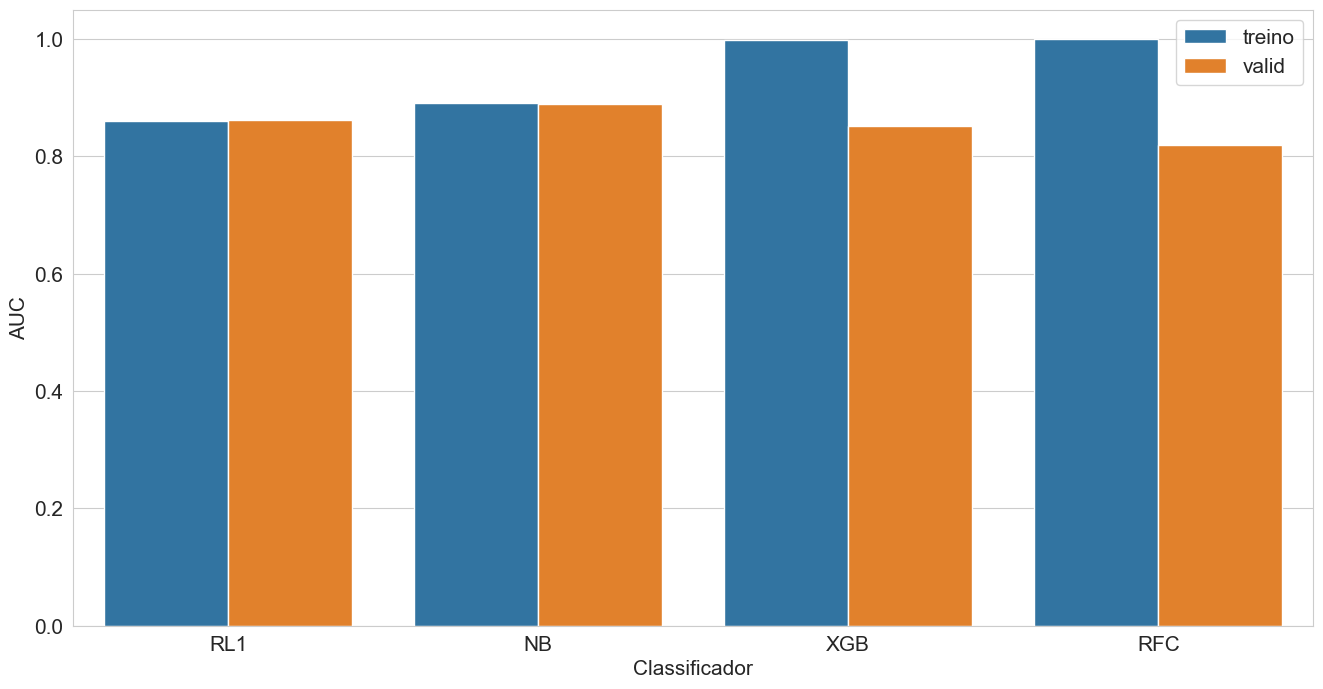

In [59]:
# Construção do Plot
sns.set_style("whitegrid")
plt.figure(figsize = (16, 8))

# Gráfico de barras
ax = sns.barplot(x = 'classificador', y = 'auc', hue = 'data_set', data = df_results)
ax.set_xlabel('Classificador', fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize = 15)

# Legenda
plt.legend(fontsize = 15)

O modelo Naive-Bayes teve o melhor resultado na métrica ROC-AUC nos dados de validação e será escolhido. Apesar desse modelo fazer fortes suposições sobre a independência das variáveis, será assumido que os dados foram selecionados para satisfazer essa suposição.

## Otimização de hiperparâmetros e validação cruzada

In [63]:
%%time

# Importa a função GridSearchCV
from sklearn.model_selection import GridSearchCV

# Defina o espaço de busca dos hiperparâmetros
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

# Cria o classificador com RandomForest
classificador = GaussianNB()

# Configura o GridSearchCV
grid_search = GridSearchCV(estimator = classificador, 
                           param_grid = param_grid, 
                           cv = 5, 
                           scoring = 'roc_auc', 
                           verbose = 2, 
                           n_jobs = -1)

# Treina o modelo com validação cruzada e busca pelos melhores hiperparâmetros
modelo_v2_otimizado = grid_search.fit(X_treino_tf, y_treino)

# Melhores hiperparâmetros encontrados
print('Melhores hiperparâmetros:', modelo_v2_otimizado.best_params_)

# Previsões
y_train_preds = modelo_v2_otimizado.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v2_otimizado.predict_proba(X_valid_tf)[:,1]

print('Modelo Random Forest Classifier com Otimização de Hiperparâmetros e Validação Cruzada:\n')

print('Treinamento:\n')
rfc_train_auc, rfc_train_accuracy, rfc_train_recall, rfc_train_precision, rfc_train_specificity = report(y_treino, 
                                                                                                                   y_train_preds, 
                                                                                                                   thresh)

print('Validação:\n')
rfc_valid_auc, rfc_valid_accuracy, rfc_valid_recall, rfc_valid_precision, rfc_valid_specificity = report(y_valid, 
                                                                                                                   y_valid_preds, 
                                                                                                                   thresh)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Melhores hiperparâmetros: {'var_smoothing': 4.328761281083053e-06}
Modelo Random Forest Classifier com Otimização de Hiperparâmetros e Validação Cruzada:

Treinamento:

AUC:0.890
Acurácia:0.807
Recall:0.802
Precisão:0.809
Especificidade:0.811
 
Validação:

AUC:0.889
Acurácia:0.810
Recall:0.814
Precisão:0.317
Especificidade:0.810
 
CPU times: total: 3.88 s
Wall time: 35 s


Apesar de não ter tido aumento significativo, o modelo com tunning dos hiperparâmetros será escolhido, pois em grandes volumes de dados a diferença pode ser significativa na geração de receita do banco.Além disso, o tempo de processamento foi curto.

## Seleção do melhor modelo

In [64]:
# Grava o modelo em disco
pickle.dump(modelo_v2_otimizado, open('melhor_modelo.pkl', 'wb'), protocol = 4)

In [66]:
# Carrega o modelo, as colunas e o scaler
best_model = pickle.load(open('melhor_modelo.pkl','rb'))
cols_input = pickle.load(open('colunas_entrada.sav','rb'))
scaler = pickle.load(open('scaler.sav', 'rb'))

# Carrega os dados
df_train = pd.read_csv('dados_treino_final.csv')
df_valid = pd.read_csv('dados_valid.csv')
df_test = pd.read_csv('dados_teste.csv')

# Cria matrizes x e y

# X
X_train = df_train[cols_input].values
X_valid = df_valid[cols_input].values
X_test = df_test[cols_input].values

# Y
y_train = df_train['target'].values
y_valid = df_valid['target'].values
y_test = df_test['target'].values

# Aplica a transformação nos dados
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)
X_test_tf = scaler.transform(X_test)

In [67]:
# Previsões de probabilidade
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

In [68]:
thresh = 0.5

print('\nTreinamento:\n')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = report(y_train, y_train_preds, 
                                                                                               thresh)

print('\nValidação:\n')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = report(y_valid, y_valid_preds, 
                                                                                               thresh)

print('\nTeste:\n')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = report(y_test, y_test_preds, 
                                                                                          thresh)


Treinamento:

AUC:0.890
Acurácia:0.807
Recall:0.802
Precisão:0.809
Especificidade:0.811
 

Validação:

AUC:0.889
Acurácia:0.810
Recall:0.814
Precisão:0.317
Especificidade:0.810
 

Teste:

AUC:0.888
Acurácia:0.807
Recall:0.801
Precisão:0.321
Especificidade:0.808
 


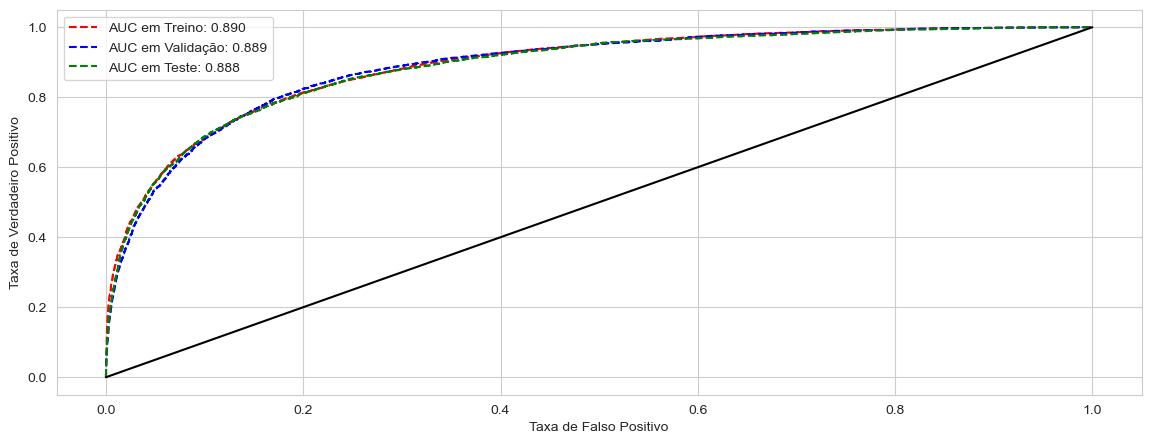

In [69]:
# Calcula a curva ROC nos dados de treino
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

# Calcula a curva ROC nos dados de validação
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

# Calcula a curva ROC nos dados de teste
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

# Plot
plt.figure(figsize=(14,5))
plt.plot(fpr_train, tpr_train, 'r--', label = 'AUC em Treino: %.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b--', label = 'AUC em Validação: %.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g--', label = 'AUC em Teste: %.3f'%auc_test)
plt.plot([0,1],[0,1], 'k-')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.legend()
plt.show()

## Deploy do Modelo

In [70]:
# Carregando dados de novos clientes
novos_clientes = pd.read_csv('test.csv')

In [76]:
novos_clientes.drop(columns = 'ID_code', inplace = True)

In [77]:
novos_clientes

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,13.1678,1.0136,10.4333,6.7997,8.5974,-4.1641,4.8579,14.7625,-2.7239,6.9937,...,2.0544,9.6849,4.6734,-1.3660,12.8721,1.2013,-4.6195,9.1568,18.2102,4.8801
199996,9.7171,-9.1462,7.3443,9.1421,12.8936,3.0191,5.6888,18.8862,5.0915,6.3545,...,5.0071,6.6548,1.8197,2.4104,18.9037,-0.9337,2.9995,9.1112,18.1740,-20.7689
199997,11.6360,2.2769,11.2074,7.7649,12.6796,11.3224,5.3883,18.3794,1.6603,5.7341,...,5.1536,2.6498,2.4937,-0.0637,20.0609,-1.1742,-4.1524,9.1933,11.7905,-22.2762
199998,13.5745,-0.5134,13.6584,7.4855,11.2241,-11.3037,4.1959,16.8280,5.3208,8.9032,...,3.4259,8.5012,2.2713,5.7621,17.0056,1.1763,-2.3761,8.1079,8.7735,-0.2122


In [78]:
# Aplica a padronização nos novos dados
novos_clientes_scaled = scaler.transform(novos_clientes)

In [79]:
novos_clientes_scaled

array([[ 0.05979962,  2.20045785,  0.74057479, ...,  1.9920356 ,
        -0.05780962, -0.54729377],
       [-0.7493332 ,  0.62681147,  0.13846845, ...,  1.08248779,
         1.10896145, -1.72048735],
       [-1.7220352 , -2.17355803, -0.28657357, ..., -1.92890217,
         1.35344387, -1.9314005 ],
       ...,
       [ 0.24184812,  0.87341492,  0.10293873, ...,  0.35568557,
        -1.23242914, -1.84494468],
       [ 0.86053854,  0.20052464,  0.997937  , ..., -0.8076696 ,
        -2.19498097,  0.26705839],
       [-0.13144067,  0.76009695, -0.25480496, ...,  1.58238538,
        -0.42094402, -0.45058616]])

In [80]:
# Aplica o modelo nos dados novos
best_model.predict_proba(novos_clientes_scaled)

array([[0.52550318, 0.47449682],
       [0.38665079, 0.61334921],
       [0.2729273 , 0.7270727 ],
       ...,
       [0.98251446, 0.01748554],
       [0.54714602, 0.45285398],
       [0.55830849, 0.44169151]])

In [81]:
# Calcula as previsões com base nos dados
best_model.predict(novos_clientes_scaled)

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [82]:
# Incorpora as previsões ao dataset
novos_clientes['target'] = best_model.predict(novos_clientes_scaled)

In [83]:
novos_clientes

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,...,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197,0
1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,...,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760,1
2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,...,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794,1
3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,...,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108,0
4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,...,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,13.1678,1.0136,10.4333,6.7997,8.5974,-4.1641,4.8579,14.7625,-2.7239,6.9937,...,9.6849,4.6734,-1.3660,12.8721,1.2013,-4.6195,9.1568,18.2102,4.8801,0
199996,9.7171,-9.1462,7.3443,9.1421,12.8936,3.0191,5.6888,18.8862,5.0915,6.3545,...,6.6548,1.8197,2.4104,18.9037,-0.9337,2.9995,9.1112,18.1740,-20.7689,0
199997,11.6360,2.2769,11.2074,7.7649,12.6796,11.3224,5.3883,18.3794,1.6603,5.7341,...,2.6498,2.4937,-0.0637,20.0609,-1.1742,-4.1524,9.1933,11.7905,-22.2762,0
199998,13.5745,-0.5134,13.6584,7.4855,11.2241,-11.3037,4.1959,16.8280,5.3208,8.9032,...,8.5012,2.2713,5.7621,17.0056,1.1763,-2.3761,8.1079,8.7735,-0.2122,0


## Conclusão

Anonimização dos dados: a falta de informação sobre as variáveis prejudica a interpretabilidade do modelo construído e prejudica a tomada de decisão com base nas previsões gerada, principalmente se a variável alvo se tratar de transações que possam gerar prejuízos ao banco. Apesar disso, ela traz uma abordagem em conformidade com as normas da LGPD.

Suposições: o modelo foi selecionado com base na suposição da independência entre as informações dos clientes. Essa é uma fragilidade potencializada pela anonimização dos dados.

Técnica de balanceamento: para a remoção de viés dos modelos, foi utilizado o Undersampling, o qual nivela o número de amostras por baixo. Isso diminuiu muito o tamanho do dataset de treino, fazendo com que esses dados fossem menores do que os de validação e teste. Assim, é provável que a performance do modelo selecionado tenha sido prejudicada pela baixa disponibilidade de dados de treino.

_Recomendação à area de negócio_: Revisar a necessidade de anonimização completa dos dados para que seja possível interpretar os modelos, de forma a possibilitar a tomada de decisão para os novos clientes de maneira orientada pelos dados, especialmente se a variável alvo representar transações de risco para o banco